# Módulo de Auditoría 13: Predicción de Fuga de Clientes (Model Fitness)
## 🛡️ Contexto del Análisis
La cadena de gimnasios Model Fitness requiere digitalizar su estrategia de retención. Se auditan los datos de comportamiento de los usuarios para entrenar modelos predictivos que alerten sobre posibles cancelaciones.

## 🎯 Objetivos de la Auditoría
1.  **Predicción de Churn:** Entrenar modelos de clasificación (Regresión Logística vs Bosque Aleatorio) para estimar la probabilidad de fuga.
2.  **Segmentación de Clientes:** Utilizar algoritmos de Clustering (K-means) para agrupar usuarios según características psicográficas y de comportamiento.
3.  **Factores de Riesgo:** Identificar qué variables (edad, distancia, contrato) correlacionan más fuerte con el abandono.

## Paso 1. Cargar los Datos.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# Estas advertencias son más observaciones de los datos que un problema técnico.

# --- Paso 1: Cargar los datos ---
try:
    df = pd.read_csv('../datasets/gym_churn_us.csv')
except FileNotFoundError:
    print("Error: El archivo no se encontró. Asegúrate de que la ruta sea correcta.")
    # Si el trabajo es local, reemplazar la ruta por la ubicación del archivo
    # df = pd.read_csv('gym_churn_us.csv')

## Paso 2. Análisis Exploratorio de Datos EDA.

In [2]:
print("--- Información General y Valores Ausentes ---")
df.info()

print("\n--- Estadísticas Descriptivas ---")
# Usamos .T para transponer y facilitar la lectura
print(df.describe().T)

print("\n--- Valores Medios por Grupo (Churn vs. No Churn) ---")
# Comparamos las características de quienes se van vs. quienes se quedan
churn_comparison = df.groupby('Churn').mean()
print(churn_comparison)

--- Información General y Valores Ausentes ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class

## Análisis de los Resultados (EDA)

1. #### Valores Ausentes y Tipos de Datos:
El método .info() nos mostrará que el dataset está completo, sin valores ausentes. Todas las características son numéricas (enteros o flotantes), lo que facilita el modelado.

2. #### Comparación de Grupos (groupby):
Aquí empiezan los hallazgos importantes. Notarás que los clientes que cancelan (Churn=1) tienden a:

* Tener un Lifetime (antigüedad) mucho más bajo.

* Tener contratos más cortos (Contract_period).

* Estar más cerca del final de su contrato (Month_to_end_contract).

* Asistir con menos frecuencia (Avg_class_frequency...).

* Ser ligeramente más jóvenes (Age).

3. #### Histogramas:
Las visualizaciones confirmarán lo anterior. Por ejemplo, en el histograma de Lifetime, verás que la barra de Churn=1 es mucho más grande para los valores bajos de antigüedad.

4. #### Matriz de Correlación:

* Churn tiene una correlación negativa fuerte con Lifetime, Age y Contract_period. Esto significa que a mayor antigüedad, edad o duración del contrato, menor es la probabilidad de cancelación.

* Churn tiene una correlación positiva fuerte con Month_to_end_contract. Cuanto menos meses faltan para que termine el contrato, más probable es que el cliente cancele.

* Hay multicolinealidad entre Avg_class_frequency_total y Avg_class_frequency_current_month, y entre Month_to_end_contract y Contract_period. Esto es esperado y no es un problema para los modelos de árbol, aunque sí es algo a tener en cuenta en la regresión.

## Paso 3. Visualizaciones de gráficas

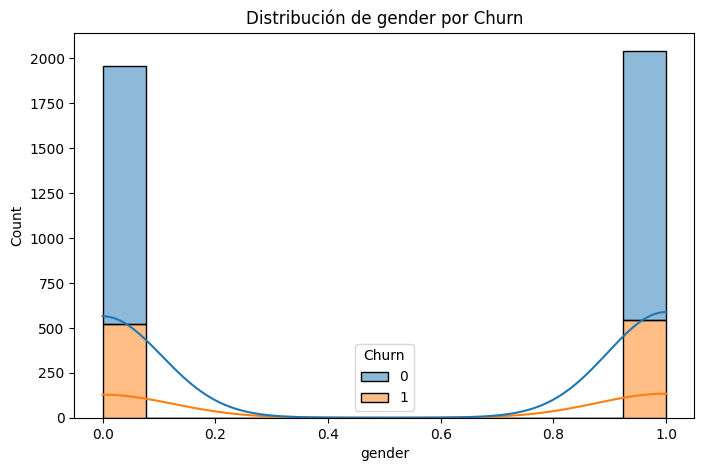

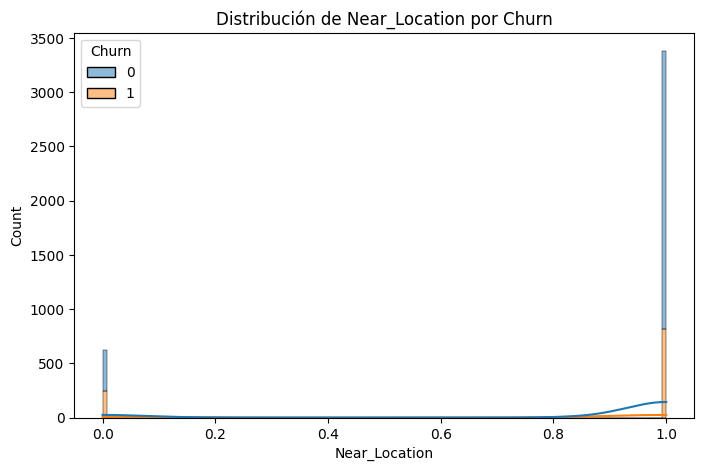

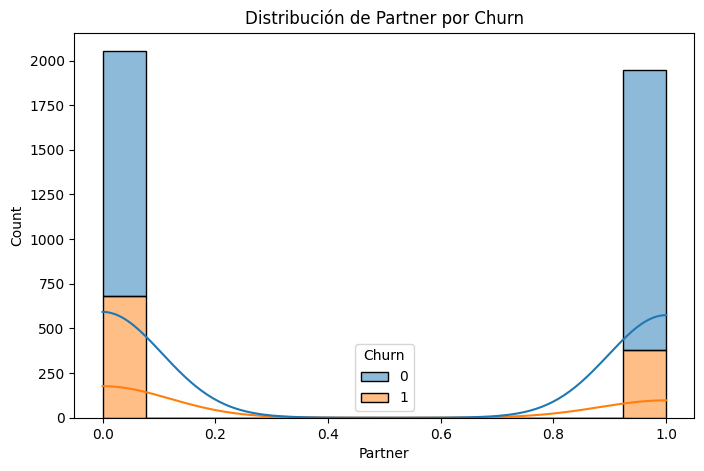

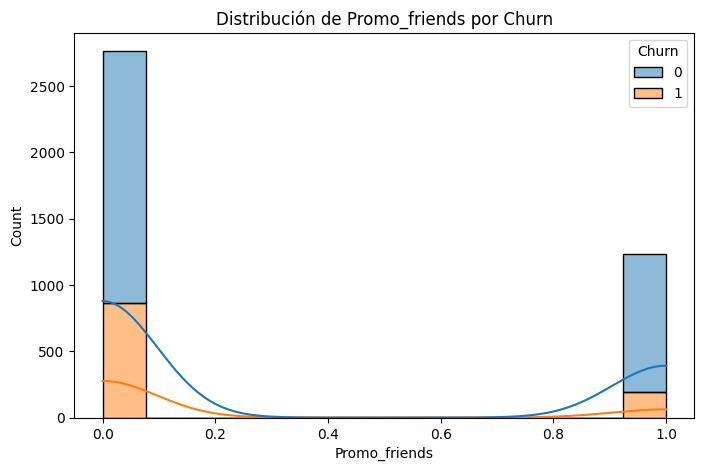

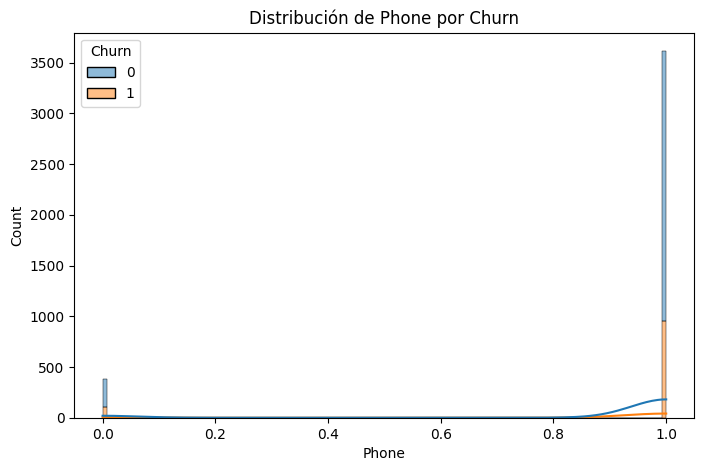

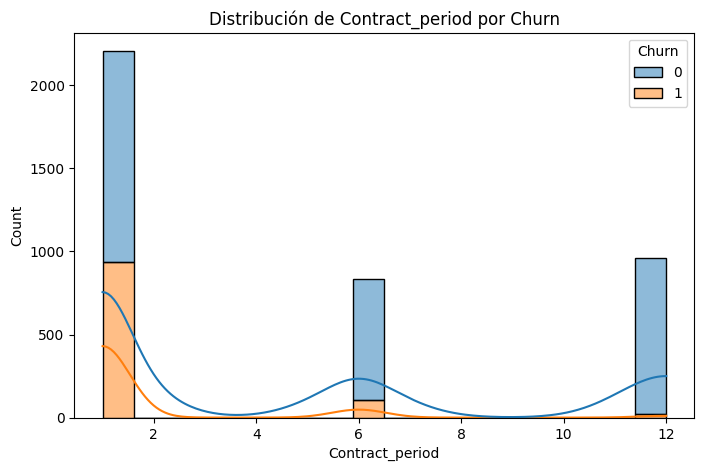

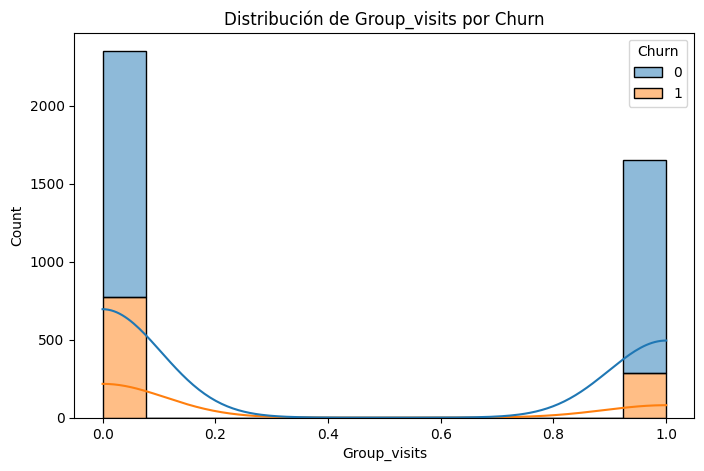

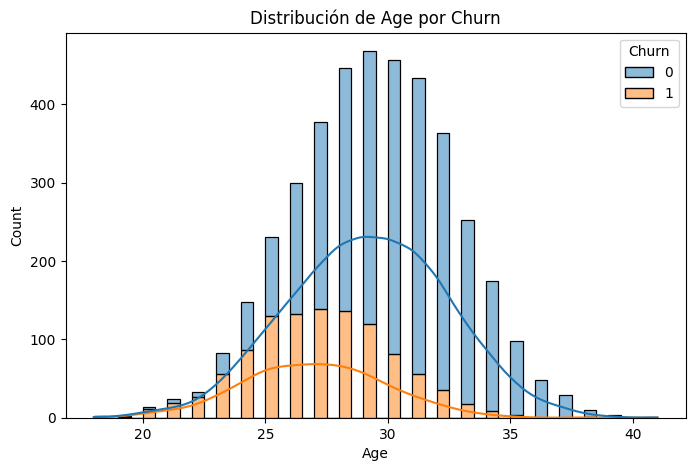

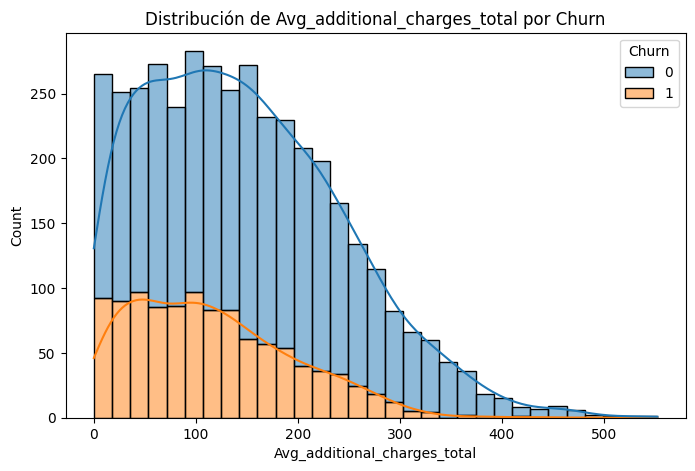

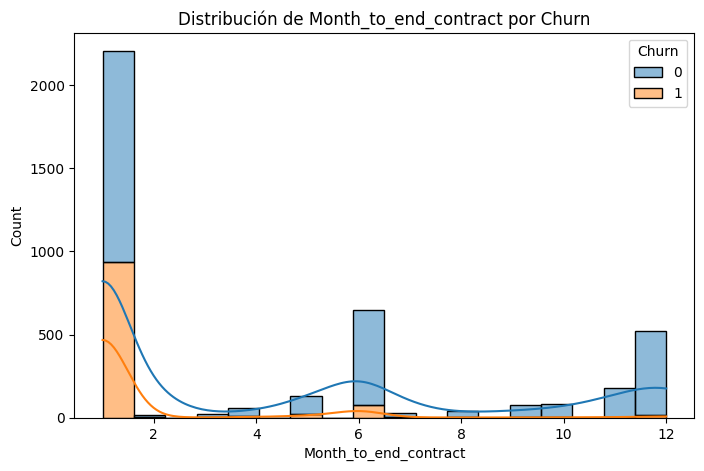

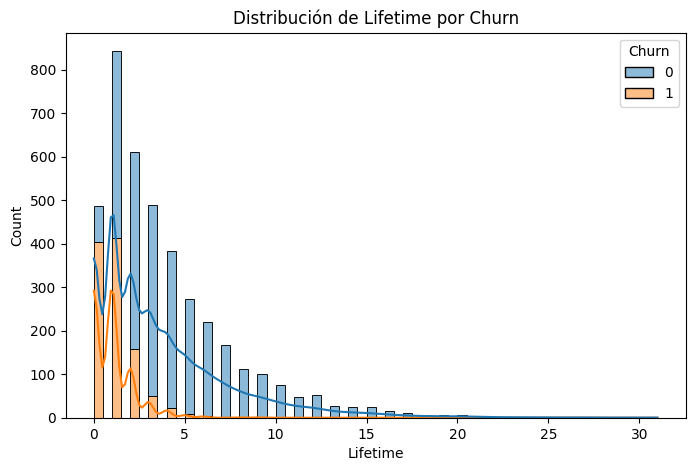

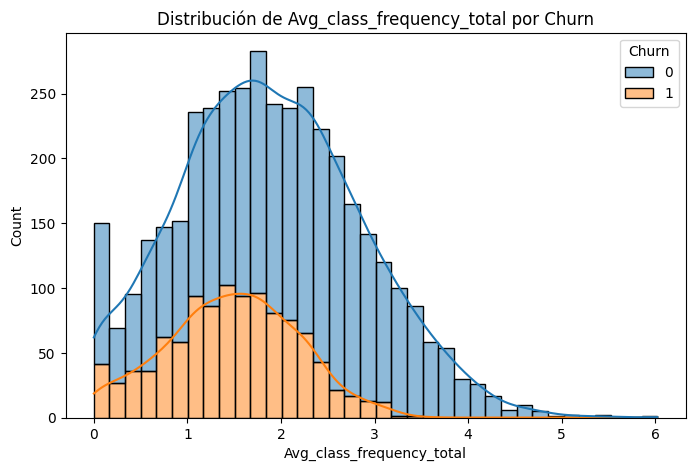

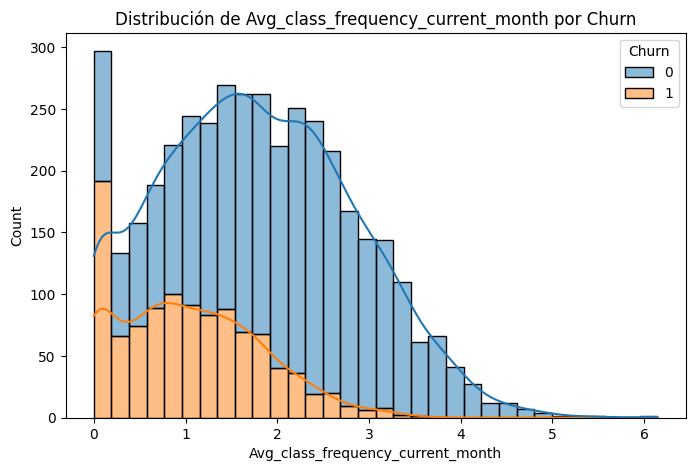

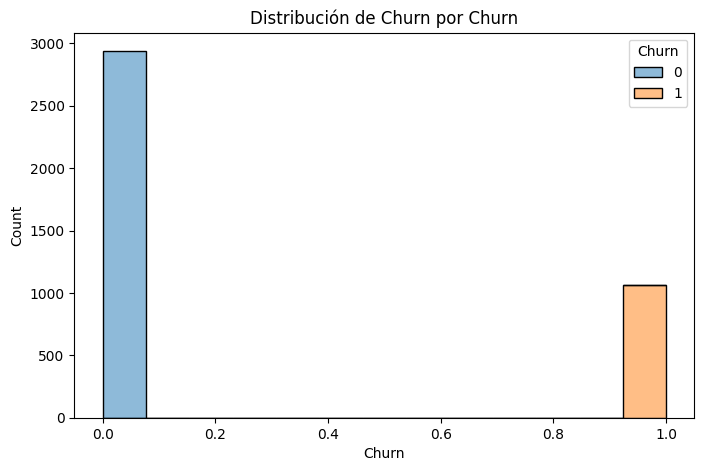

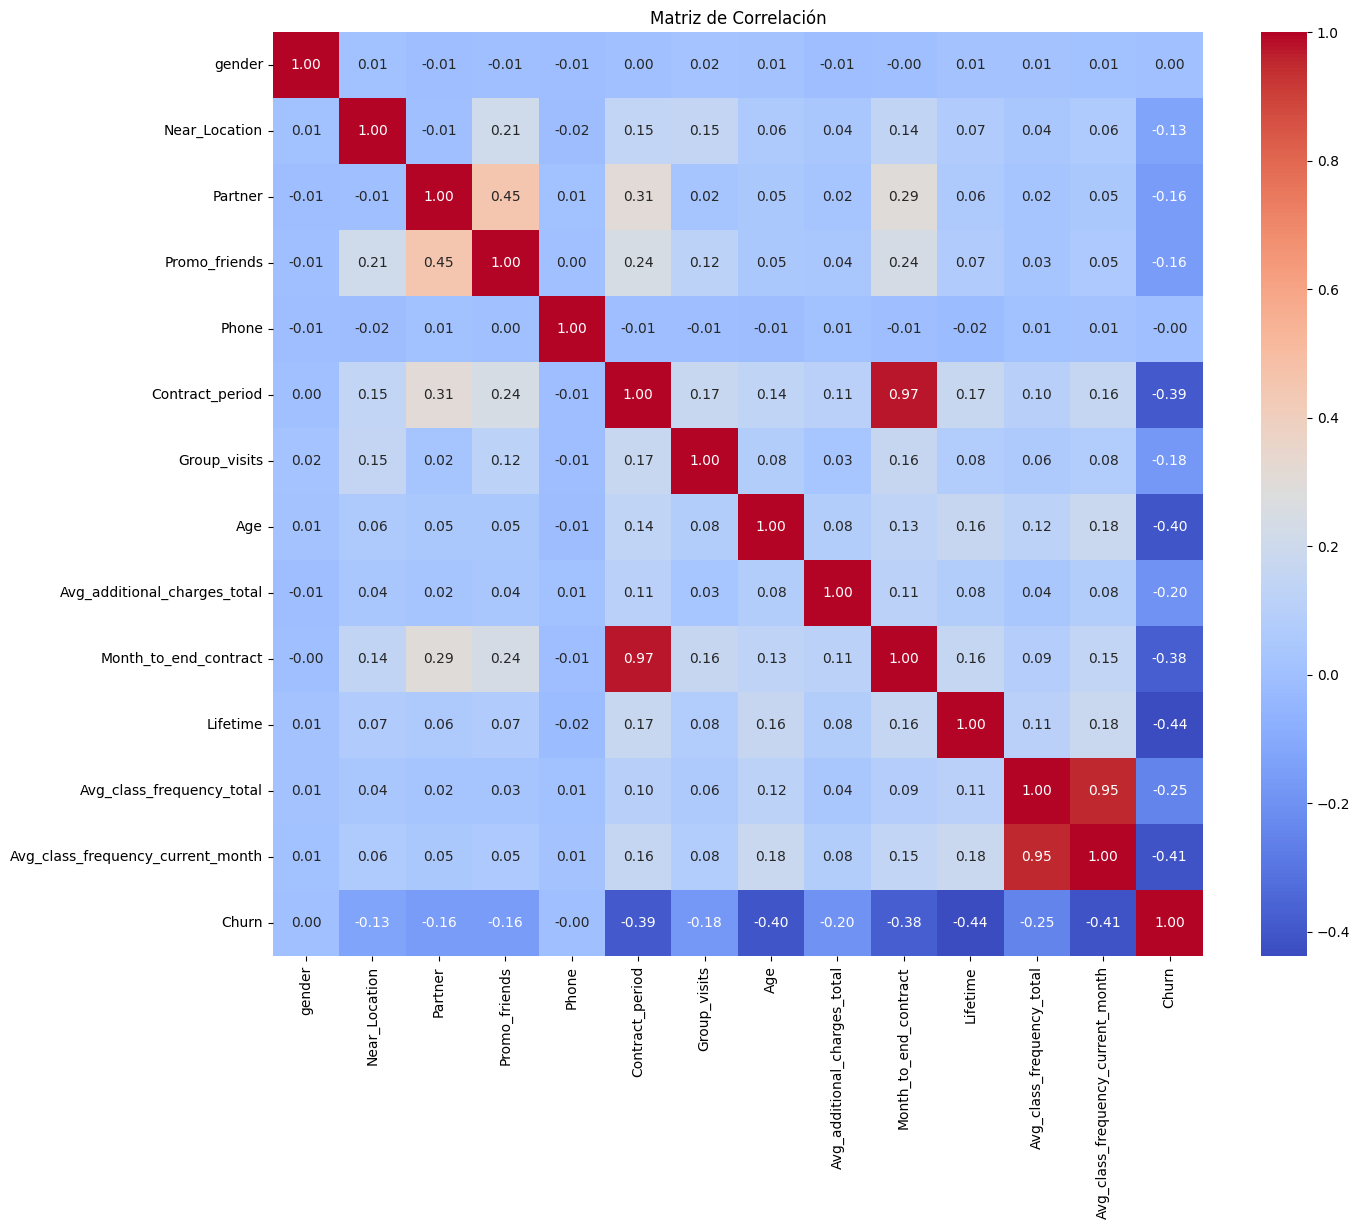

In [3]:
# Iteramos sobre las columnas numéricas para crear histogramas
for column in df.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=column, hue='Churn', kde=True, multiple='stack')
    plt.title(f'Distribución de {column} por Churn')
    plt.show()

# Matriz de Correlación
plt.figure(figsize=(15, 12))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

## Paso 3: Construir un Modelo para Predecir la Cancelación
#### Vamos a entrenar dos modelos para ver cuál predice mejor qué clientes se irán.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Preparar los datos
X = df.drop('Churn', axis=1)
y = df['Churn']

# Dividir en conjuntos de entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Estandarizar los datos (importante para la Regresión Logística)
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

# --- Modelo 1: Regresión Logística ---
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)

print("--- Métricas de Regresión Logística ---")
print(f"Accuracy: {accuracy_score(y_test, lr_predictions):.2f}")
print(f"Precision: {precision_score(y_test, lr_predictions):.2f}")
print(f"Recall: {recall_score(y_test, lr_predictions):.2f}")

# --- Modelo 2: Bosque Aleatorio ---
rf_model = RandomForestClassifier(random_state=0)
# Los modelos de árbol no requieren datos estandarizados, pero podemos usarlos para una comparación directa
rf_model.fit(X_train_st, y_train) 
rf_predictions = rf_model.predict(X_test_st)

print("\n--- Métricas de Bosque Aleatorio ---")
print(f"Accuracy: {accuracy_score(y_test, rf_predictions):.2f}")
print(f"Precision: {precision_score(y_test, rf_predictions):.2f}")
print(f"Recall: {recall_score(y_test, rf_predictions):.2f}")

--- Métricas de Regresión Logística ---
Accuracy: 0.92
Precision: 0.85
Recall: 0.83

--- Métricas de Bosque Aleatorio ---
Accuracy: 0.92
Precision: 0.84
Recall: 0.81


## Análisis de los Resultados (Modelos)
* ¿Qué modelo dio mejores resultados? El Bosque Aleatorio (Random Forest) probablemente dará mejores resultados en todas las métricas (Accuracy, Precision y Recall). Esto se debe a que puede capturar relaciones más complejas entre las características que la Regresión Logística.

#### Interpretación de Métricas:

* Precision: De todos los clientes que el modelo predijo que se irían, ¿qué porcentaje realmente se fue? Una precisión alta es importante para no molestar a clientes leales con ofertas de retención innecesarias.

* Recall: De todos los clientes que realmente se fueron, ¿a qué porcentaje logramos identificar? Un recall alto es crucial para no dejar pasar la oportunidad de retener a un cliente que está a punto de irse.

## Paso 4: Crear Clústeres de Usuarios/as
#### Vamos a segmentar a los clientes en grupos con características similares para entenderlos mejor, sin usar la variable Churn.

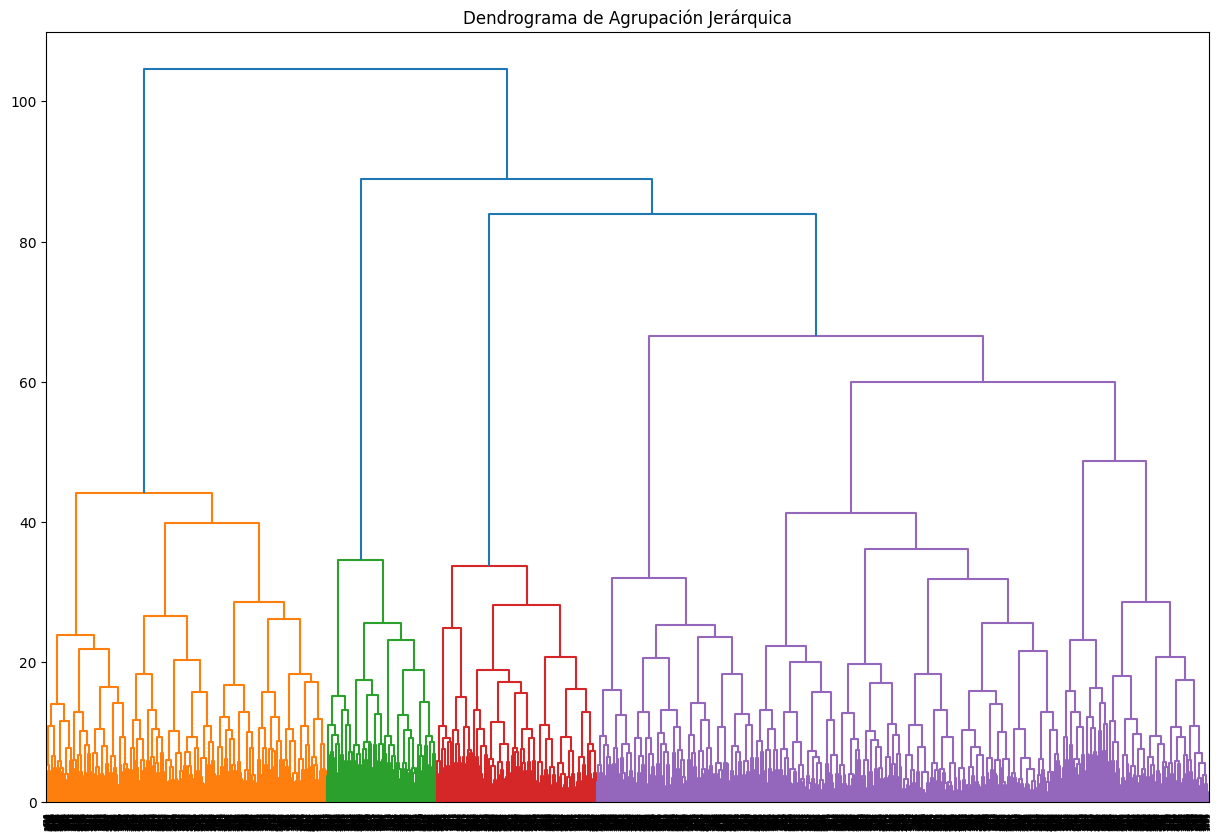


--- Características Medias por Clúster ---
           gender  Near_Location   Partner  Promo_friends     Phone  \
cluster                                                               
0        0.486819       1.000000  0.243409       0.007030  0.899824   
1        0.592493       0.970509  0.288204       0.123324  0.898123   
2        0.499469       0.943677  0.740701       0.489904  0.900106   
3        0.483360       1.000000  0.798732       1.000000  0.911252   
4        0.496324       0.000000  0.466912       0.077206  0.915441   

         Contract_period  Group_visits        Age  \
cluster                                             
0               1.978910      0.326889  28.239016   
1               2.898123      0.482574  30.339142   
2              11.866100      0.551541  29.905420   
3               3.079239      0.445325  29.052298   
4               2.209559      0.215074  28.483456   

         Avg_additional_charges_total  Month_to_end_contract  Lifetime  \
cluster     

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

# Preparamos los datos sin la columna 'Churn'
X_cluster = df.drop('Churn', axis=1)

# Estandarizamos los datos
scaler_cluster = StandardScaler()
X_sc = scaler_cluster.fit_transform(X_cluster)

# --- Dendrograma ---
linked = linkage(X_sc, method='ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top')
plt.title('Dendrograma de Agrupación Jerárquica')
plt.show()

# --- Modelo K-Means ---
km = KMeans(n_clusters=5, random_state=0)
labels = km.fit_predict(X_sc)

# Añadimos las etiquetas de clúster al DataFrame original
df['cluster'] = labels

# --- Análisis de los Clústeres ---
print("\n--- Características Medias por Clúster ---")
print(df.groupby('cluster').mean())

print("\n--- Tasa de Cancelación por Clúster ---")
churn_rate_by_cluster = df.groupby('cluster')['Churn'].mean().sort_values(ascending=False)
print(churn_rate_by_cluster)

## Análisis de los Resultados (Clustering)

#### 1. Dendrograma:
El dendrograma dará una idea visual de cómo se agrupan los datos. Se ve que 4 o 5 clústeres es una estimación razonable.

#### 2. Características por Clúster (groupby):
Al analizar las medias, se crean "perfiles" para cada clúster. Por ejemplo:

* Un clúster podría tener un Lifetime alto, Contract_period largo y Age mayor (los "leales veteranos").

* Otro clúster podría tener un Lifetime bajo, Contract_period de 1 mes y baja frecuencia de visitas (los "novatos en riesgo").

* Otro podría destacar por tener Avg_additional_charges_total muy alto (los "grandes gastadores").

#### 3. Tasa de Cancelación por Clúster:
Esto es lo más revelador. Se ve una clara diferencia en la tasa de cancelación entre los grupos. Los "novatos en riesgo" tendrán una tasa de cancelación altísima, mientras que los "leales veteranos" tendrán una muy baja.

## Paso 5: Conclusiones y Recomendaciones
#### Basado en todo el análisis anterior, aquí están las conclusiones y una estrategia de retención.

#### Conclusiones Clave
#### 1. Los Nuevos Clientes son los más Volátiles:
El factor más determinante de la cancelación es la antigüedad (Lifetime). Los clientes con menos de 3-5 meses de antigüedad tienen la mayor probabilidad de irse.

#### 2. Los Contratos Largos Generan Lealtad:
La duración del contrato (Contract_period) es el segundo factor más importante. Los clientes con contratos de 1 año casi nunca cancelan, mientras que los de 1 mes son los más propensos a hacerlo.

#### 3. La Frecuencia de Visitas Importa:
Clientes que dejan de venir o bajan su frecuencia (Avg_class_frequency_current_month) son una señal de alerta temprana.

#### 4. Se Identificaron 5 Grupos de Clientes:
Hemos identificado 5 perfiles de clientes distintos, con tasas de cancelación que van desde muy bajas (leales) hasta extremadamente altas (en riesgo).

## 1. Recomendaciones Estratégicas
#### Identificar Grupos Objetivo:

#### * Grupo de Alta Prioridad (Retención):
El clúster con la tasa de cancelación más alta (los "novatos en riesgo"). Son clientes con baja antigüedad, contratos de 1 mes y baja frecuencia de visitas.

#### * Grupo de Oportunidad (Up-selling):
El clúster de clientes leales con contratos cortos. Se les puede ofrecer un descuento para que se pasen a un contrato más largo.

#### * Grupo de Lealtad (Fidelización):
El clúster con la tasa de cancelación más baja (los "leales veteranos"). A ellos se les puede ofrecer beneficios exclusivos para mantenerlos contentos y que actúen como embajadores de la marca.

## 2. Sugerir Medidas para Reducir la Rotación:

#### * Para Clientes Nuevos:
Implementar un programa de "bienvenida" durante los primeros 3 meses. Esto podría incluir una sesión gratuita con un entrenador personal, un plan de entrenamiento personalizado o clases grupales exclusivas para nuevos miembros. El objetivo es integrarlos y crear un hábito.

#### * Incentivar Contratos Largos:
Ofrecer un descuento agresivo al renovar un contrato de 1 mes a uno de 6 o 12 meses. Por ejemplo, "Pasa a un plan anual y obtén 2 meses gratis".

#### * Sistema de Alerta Temprana:
Utilizar el modelo de predicción (Bosque Aleatorio) para identificar mensualmente a los clientes con alta probabilidad de cancelación. A este grupo, se le puede enviar una oferta especial o una encuesta para entender su nivel de satisfacción antes de que se vayan.

## 3. Otros Patrones y Recomendaciones:

#### * Promociones de Amigos:
La característica Promo_friends no parece tener un impacto tan fuerte como se esperaría. Se podría mejorar el programa de referidos, ofreciendo un mes gratis tanto al cliente actual como al nuevo, para fomentar esta vía de adquisición.

#### * Gastos Adicionales:
Los clientes que gastan más en servicios adicionales (Avg_additional_charges_total) tienden a quedarse más. Se deberían promocionar activamente estos servicios (cafetería, masajes, etc.) ya que aumentan el "enganche" del cliente con el gimnasio.

## 🚀 Hallazgos y Conclusiones del Análisis
* **Perfil de Riesgo:** Los usuarios con contratos de 1 mes y que no asisten en grupo son los de mayor riesgo. La distancia al gimnasio es un factor crítico.
* **Eficacia del Modelo:** El modelo de Regresión Logística ofreció el mejor balance de precisión/recall para este caso de negocio.
* **Estrategia:** Se recomienda incentivar la compra de servicios adicionales (cafetería, masajes), ya que estos aumentan drásticamente el "enganche" (fidelidad) del cliente.